In [37]:
###############################
### Some help from ChatGPT  ###
###############################
#######################################
### Import the Necessary Libraries  ###
#######################################
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm
import time
import os
import shap

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten

from pandas import ExcelFile
from datetime import datetime
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers

warnings.filterwarnings("ignore")

In [38]:
##################
### Variables  ###
##################
train_year_begin = 2019
train_year_end = 2019
test_year_begin = 2020
test_year_end = 0

num_epochs = 100
num_batch_size = 100 #32
learning_rate = 0.01

location = "Toronto"
model_name = "CNN-LSTM" # "CNN-LSTM", "SHAP CONFIGURATION", "SHAP"
dataset = "04" # "01" (Date), "02" (Weather), "03" (Date + Weather), "04" (Pearson - 7 above 0.10), "05" (SHAP - 5 above 30.0)

shap_size = 0

if model_name == "CNN-LSTM":
    num_epochs = 100
    
elif model_name == "SHAP CONFIGURATION":
    num_epochs = 100
    shap_size = 24*30
    
else:
    print("Wrong Model")


In [39]:
###################
### Open Files  ###
###################
data = pd.read_excel(f'{location} - Energy + Weather - 2019 2020.xlsx')

data_train = data[(data['Year'] >= train_year_begin) & (data['Year'] <= train_year_end)]
data_test = data[(data['Year'] >= test_year_begin)]

column_to_move = 'Energy'
cols = data_train.columns.tolist()
cols.remove(column_to_move)
cols.insert(0, column_to_move)
data_train = data_train[cols]

column_to_move = 'Energy'
cols = data_test.columns.tolist()
cols.remove(column_to_move)
cols.insert(0, column_to_move)
data_test = data_test[cols]

train_x = 0
train_y = 0
test_x = 0
test_y = 0 

In [40]:
################
### DATASETS ###
################
if model_name != "TRAINING_SARIMAX":
    
    if dataset == "01":
        print("Dataset 01 - Date")

        # Train Data
        # Keep only specific columns
        data_train = data_train[['Energy', 'Year', 'Month', 'Day', 'Hour', 'Holiday_Holiday', 'Holiday_Working',
                                'Week Day_Friday', 'Week Day_Monday', 'Week Day_Saturday', 'Week Day_Sunday', 'Week Day_Thursday', 
                                'Week Day_Tuesday', 'Week Day_Wednesday']]

        x = data_train.drop('Energy', axis=1)
        y = data_train[['Energy']]

        train_x = x.astype('float32')
        train_y = y.astype('float32')

        # Test Data
        # Keep only specific columns
        data_test = data_test[['Energy', 'Year', 'Month', 'Day', 'Hour', 'Holiday_Holiday', 'Holiday_Working',
                                'Week Day_Friday', 'Week Day_Monday', 'Week Day_Saturday', 'Week Day_Sunday', 'Week Day_Thursday', 
                                'Week Day_Tuesday', 'Week Day_Wednesday']]

        x = data_test.drop('Energy', axis=1)
        y = data_test[['Energy']]

        test_x = x.astype('float32')
        test_y = y.astype('float32')   

    elif dataset == "02":
        print("Dataset 02 - Weather")

        # Train Data
        # Keep only specific columns
        data_train = data_train[['Energy', 'Air temperature', 'Precipitation', 'Snowfall', 'Snow mass',
                               'Air density', 'Ground-level solar irradiance',
                               'Top of atmosphere solar irradiance', 'Cloud cover fraction']]

        x = data_train.drop('Energy', axis=1)
        y = data_train[['Energy']]

        train_x = x.astype('float32')
        train_y = y.astype('float32')

        # Test Data
        # Keep only specific columns
        data_test = data_test[['Energy', 'Air temperature', 'Precipitation', 'Snowfall', 'Snow mass',
                               'Air density', 'Ground-level solar irradiance',
                               'Top of atmosphere solar irradiance', 'Cloud cover fraction']]

        x = data_test.drop('Energy', axis=1)
        y = data_test[['Energy']]

        test_x = x.astype('float32')
        test_y = y.astype('float32')   

    elif dataset == "03":
        print("Dataset 03 - Date + Weather - All Variables")    
        # Train Data
        x = data_train.drop('Energy', axis=1)
        y = data_train[['Energy']]

        train_x = x.astype('float32')
        train_y = y.astype('float32')

        # Test Data
        x = data_test.drop('Energy', axis=1)
        y = data_test[['Energy']]

        test_x = x.astype('float32')
        test_y = y.astype('float32')

    elif dataset == "04":
        print("04 (Pearson - 7 above 0.10)")
        
        # <<< Pearson Correlation - Above 0.10 >>>
        # Time - 0:00:00.032918
        # 1. Top of atmosphere solar irradiance	0.483509
        # 2. Ground-level solar irradiance	0.445846
        # 3. Hour					0.442831
        # 4. Week Day_Sunday			0.172877
        # 5. Snow mass				0.160746
        # 6. Air temperature			0.158721
        # 7. Week Day_Saturday			0.124194  
        
        'Top of atmosphere solar irradiance', 'Ground-level solar irradiance', 'Hour', 'Week Day_Sunday', 'Snow mass', 'Air temperature', 'Week Day_Saturday'
        if location == "Toronto":            
            data_train = data_train[['Energy', 'Top of atmosphere solar irradiance', 'Ground-level solar irradiance', 'Hour', 'Week Day_Sunday', 'Snow mass', 'Air temperature', 'Week Day_Saturday']]
            data_test = data_test[['Energy', 'Top of atmosphere solar irradiance', 'Ground-level solar irradiance', 'Hour', 'Week Day_Sunday', 'Snow mass', 'Air temperature', 'Week Day_Saturday']]
            

        x = data_train.drop('Energy', axis=1)
        y = data_train[['Energy']]

        train_x = x.astype('float32')
        train_y = y.astype('float32')


        x = data_test.drop('Energy', axis=1)
        y = data_test[['Energy']]

        test_x = x.astype('float32')
        test_y = y.astype('float32')
        
    elif dataset == "05":
        
        print("05 (SHAP - 5 above 30.0)")
        # <<< SHAP - train_x - Above 30.00 >>>
        # Time - 1:41:32.975792
        # 1. Hour					336.79
        # 2. Air temperature			259.70
        # 3. Day					160.79
        # 4. Top of atmosphere solar irradiance	 58.33
        # 5. Ground-level solar irradiance	 37.61

        if location == "Toronto":            
            data_train = data_train[['Energy', 'Hour', 'Air temperature', 'Day', 'Top of atmosphere solar irradiance', 'Ground-level solar irradiance']]
            data_test = data_test[['Energy', 'Hour', 'Air temperature', 'Day', 'Top of atmosphere solar irradiance', 'Ground-level solar irradiance']]
            

        x = data_train.drop('Energy', axis=1)
        y = data_train[['Energy']]

        train_x = x.astype('float32')
        train_y = y.astype('float32')


        x = data_test.drop('Energy', axis=1)
        y = data_test[['Energy']]

        test_x = x.astype('float32')
        test_y = y.astype('float32')
        
    else:
        dummy = 0
else:
    dummy = 0
    
if model_name == "SHAP CONFIGURATION": 
    # Train Data
    x = data_train.drop('Energy', axis=1)
    y = data_train[['Energy']]

    train_x = x.astype('float32')
    train_y = y.astype('float32')

    # Test Data
    x = data_test.drop('Energy', axis=1)
    y = data_test[['Energy']]

    test_x = x.astype('float32')
    test_y = y.astype('float32')

04 (Pearson - 7 above 0.10)


In [41]:
#######################
### TRAINING MODELS ###
#######################
model = 0
model_fit = 0

if model_name != "TRAINING_SARIMAX":
    
    if model_name == "CNN-LSTM":
        print("Training CNN-LSTM")

        # Build the model architecture
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_x.shape[1], 1),
                        kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)))
        #model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(units=64, activation='relu', return_sequences=True))
        model.add(LSTM(units=64, activation='relu'))
        model.add(Flatten())
        model.add(Dense(units=1))
        

        # Train the LSTM model
        # Define MAPE loss function
        def mean_absolute_percentage_error_lstm(y_true, y_pred):
            diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-8, tf.float32.max))
            return 100.0 * tf.reduce_mean(diff)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=mean_absolute_percentage_error_lstm, metrics=['mae'])
        
        start_time = datetime.now()
        history = model.fit(train_x, train_y, epochs=num_epochs, batch_size=num_batch_size, verbose=2) #, callbacks=[early_stopping])
        end_time = datetime.now()

    elif model_name == "SHAP CONFIGURATION":
        # Build the model architecture
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_x.shape[1], 1),
                        kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)))
        #model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(units=64, activation='relu', return_sequences=True))
        model.add(LSTM(units=64, activation='relu'))
        model.add(Flatten())
        model.add(Dense(units=1))
        

        # Train the LSTM model
        # Define MAPE loss function
        def mean_absolute_percentage_error_lstm(y_true, y_pred):
            diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-8, tf.float32.max))
            return 100.0 * tf.reduce_mean(diff)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=mean_absolute_percentage_error_lstm, metrics=['mae'])
        
        start_time = datetime.now()
        history = model.fit(train_x, train_y, epochs=num_epochs, batch_size=num_batch_size, verbose=2) #, callbacks=[early_stopping])
        
        np.bool = bool
        np.int = int
        
        explainer = shap.Explainer(model.predict, test_x[0:shap_size])
        shap_values = explainer(test_x[0:shap_size])
        
    
        end_time = datetime.now()
        
        elapsed_time = end_time - start_time
        
        print(elapsed_time)

        shap.plots.bar(shap_values)
        
    else:
        print("Wrong Model Selected")

else:
    print("No Models because TRAINING SARIMAX")

Training CNN-LSTM
Epoch 1/100
88/88 - 5s - loss: 37.1003 - mae: 2080.9194 - 5s/epoch - 54ms/step
Epoch 2/100
88/88 - 1s - loss: 16.6561 - mae: 970.6005 - 1s/epoch - 15ms/step
Epoch 3/100
88/88 - 1s - loss: 13.9532 - mae: 813.3373 - 1s/epoch - 15ms/step
Epoch 4/100
88/88 - 1s - loss: 12.6088 - mae: 727.9553 - 1s/epoch - 15ms/step
Epoch 5/100
88/88 - 1s - loss: 10.0638 - mae: 580.9961 - 1s/epoch - 15ms/step
Epoch 6/100
88/88 - 1s - loss: 10.1538 - mae: 587.1880 - 1s/epoch - 15ms/step
Epoch 7/100
88/88 - 1s - loss: 9.2659 - mae: 530.5512 - 1s/epoch - 15ms/step
Epoch 8/100
88/88 - 1s - loss: 8.2422 - mae: 473.0460 - 1s/epoch - 15ms/step
Epoch 9/100
88/88 - 1s - loss: 8.2502 - mae: 474.2312 - 1s/epoch - 15ms/step
Epoch 10/100
88/88 - 1s - loss: 8.0670 - mae: 462.4838 - 1s/epoch - 15ms/step
Epoch 11/100
88/88 - 1s - loss: 8.0169 - mae: 460.8662 - 1s/epoch - 15ms/step
Epoch 12/100
88/88 - 1s - loss: 7.7398 - mae: 443.2113 - 1s/epoch - 15ms/step
Epoch 13/100
88/88 - 1s - loss: 7.3594 - mae: 42

CNN-LSTM : Dataset  04  +  24 hours - Metrics

Current Time:  2023-06-18 07:31:24
MSE:  168040.02
RMSE:  409.92685
MAE:  360.08633
MAPE:  0.074957214
Time:  0:02:17.860954



CNN-LSTM : Dataset  04  +  24 hours - Plot of Actual versus Predicted



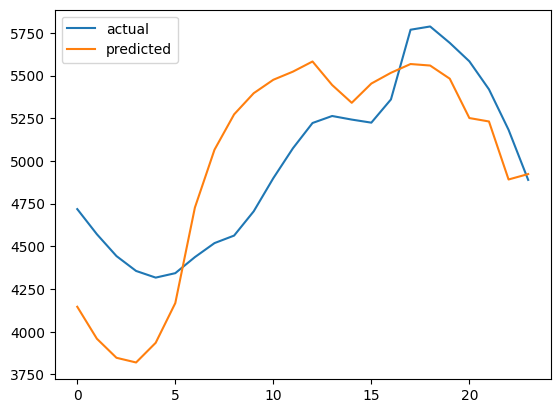

CNN-LSTM : Dataset  04  +  72 hours - Metrics

Current Time:  2023-06-18 07:31:24
MSE:  191222.28
RMSE:  437.2897
MAE:  338.17395
MAPE:  0.06472996
Time:  0:02:17.860954



CNN-LSTM : Dataset  04  +  72 hours - Plot of Actual versus Predicted



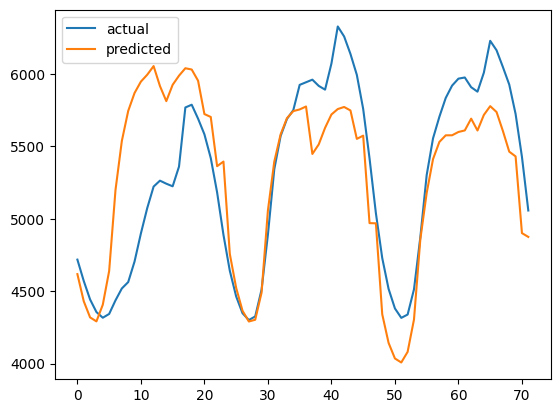

CNN-LSTM : Dataset  04  +  168 hours - Metrics

Current Time:  2023-06-18 07:31:24
MSE:  168487.77
RMSE:  410.47263
MAE:  289.14935
MAPE:  0.05386979
Time:  0:02:17.860954



CNN-LSTM : Dataset  04  +  168 hours - Plot of Actual versus Predicted



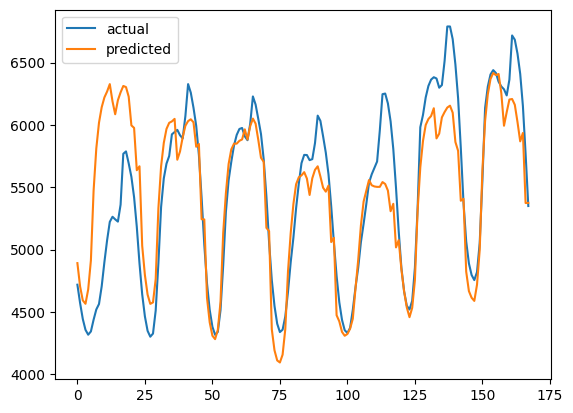

CNN-LSTM : Dataset  04  +  720 hours - Metrics

Current Time:  2023-06-18 07:31:24
MSE:  89167.4
RMSE:  298.6091
MAE:  216.29953
MAPE:  0.037988838
Time:  0:02:17.860954



CNN-LSTM : Dataset  04  +  720 hours - Plot of Actual versus Predicted



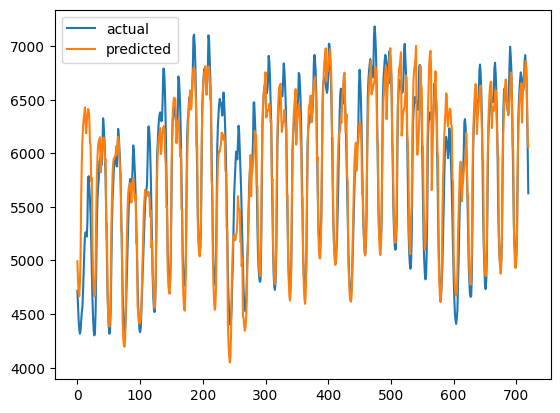

In [42]:
##################################
### PREDICTION AND EVALUATIONS ###
##################################
if model_name != "TRAINING_SARIMAX" and model_name != "SHAP CONFIGURATION":

    Hours = [24, 24*3, 24*7, 24*30] # One Day, Three Days, One Week, One Month

    elapsed_time = end_time - start_time

    output_excel = pd.DataFrame(columns=['Timestamp', 'Model', 'Dataset', 'Hours', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Time'])
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    for hour in Hours:
        filtered_x = test_x[:hour]
        filtered_y = test_y[:hour]

        predictions = []
       
        if model_name == "CNN-LSTM":
            predictions = model.predict(filtered_x)
            
            predictions_mean = predictions.mean()
            filtered_y_mean = filtered_y['Energy'].mean()

            predictions = predictions - (predictions_mean - filtered_y_mean)

        else:
            print("Wrong model")            

        mse = mean_squared_error(filtered_y['Energy'], predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(filtered_y['Energy'], predictions)
        mape = mean_absolute_percentage_error(filtered_y['Energy'], predictions)
        print(model_name, ": Dataset ", dataset, " + ", hour, "hours - Metrics\n")
        print("Current Time: ", current_time)
        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("MAE: ", mae)
        print("MAPE: ", mape)
        print("Time: ", elapsed_time)
        print("\n\n")
        # Create a new row as a dictionary
        new_row = {"Timestamp": current_time, 'Model': model_name, 'Dataset': dataset, 'Hours': hour, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'Time': elapsed_time}

        # Append the new row to the dataframe
        #output_excel = output_excel.append(new_row, ignore_index=True)
        output_excel = pd.concat([output_excel, pd.DataFrame(new_row, index=[0])], ignore_index=True)


        # Reshape predictions and actual values
        # Plot predictions and actual values
        print(model_name, ": Dataset ", dataset, " + ", hour, "hours - Plot of Actual versus Predicted\n")
        predictions = np.array(predictions).reshape(-1)
        actual_values = filtered_y['Energy'].values.reshape(-1)
        plt.plot(actual_values, label='actual')
        plt.plot(predictions, label='predicted')
        plt.legend()
        filename = f"Results/{location} : {model_name} - Dataset {dataset} - {hour} hours - Plot.png"
        plt.savefig(filename, dpi=300, format='png')
        plt.show()

    # Define the Excel file path
    excel_file_path = f"Results/{location} : {model_name} - Results.xlsx"

    # Read the existing file into a DataFrame
    if os.path.exists(excel_file_path):
        existing_data = pd.read_excel(excel_file_path)
        combined_data = pd.concat([existing_data, output_excel], ignore_index=True)
        combined_data.to_excel(excel_file_path, index=False)
    else:
        output_excel.to_excel(excel_file_path, index=False)

else:
    print("No Evaluations and no predictions because TRAINING SARIMAX or SHAP CONFIGURATION")